In [1]:
import torch, datasets, utils, math
from torch.utils.data import DataLoader, random_split

mimii_dataset_SNR = 0
N, K, query_size = 8, 5, 1
train_test_ratio = 0.2
args = utils.Args(seed=42, N=N, K=K, query_size=query_size, SNR=mimii_dataset_SNR, dataset_name='mimii', in_data_type='audio')

if args.device != "cpu":
    num_workers = 1
    if N*K <= 32:
        pin_memory = True
    else:
        pin_memory = False
else:
    num_workers = 0
    pin_memory = False

utils.global_manual_seed(seed=args.seed, device=args.device)
split_generator = torch.Generator().manual_seed(args.seed)

# 加载数据集
mimii_dataset = datasets.MIMII(root_dir=f'./data/mimii/{mimii_dataset_SNR}'+'dB_SNR',
                                machine_classes=['fan', 'pump', 'valve', 'slider'],
                                model_ids=['id_00'], categories=['abnormal', 'normal'],
                                N=N, K=K, query_size=query_size, transform='spectrogram', seed=args.seed)
print(f"数据集大小: {len(mimii_dataset)}")
train_size = math.ceil(train_test_ratio * len(mimii_dataset))
test_size = len(mimii_dataset) - train_size
train_set, test_set = random_split(mimii_dataset, [train_size, test_size], generator=split_generator)
train_loader = DataLoader(train_set, batch_size=1, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=1, num_workers=num_workers, pin_memory=pin_memory)
print(f"Train Size:{train_size}  |  Test Size:{test_size}")
print(f"选择的N个类别:{mimii_dataset.N_classes}")

数据集大小: 19
Train Size:4  |  Test Size:15
选择的N个类别:['fan_id_00_normal', 'fan_id_00_abnormal', 'valve_id_00_normal', 'pump_id_00_abnormal', 'slider_id_00_normal', 'slider_id_00_abnormal', 'valve_id_00_abnormal', 'pump_id_00_normal']


In [2]:
import nets

cnn1d_num_hidden_channels = 64
cnn2d_num_hidden_channels = 32
num_cnn1d_out_features = cnn1d_num_hidden_channels*2
num_cnn2d_out_features = cnn2d_num_hidden_channels*2
cnn1d_embed_size = 256
cnn2d_embed_size = 192
final_embed_size = 192
cross_class_conv1d_kernel_size = 4
cross_class_conv1d_stride = 4
dropout_rate = 0.5

cnn1d = nets.AudioCNN1D(num_channels_input=mimii_dataset.num_channels, 
                        num_channels_hidden=cnn1d_num_hidden_channels)
cnn2d = nets.AudioCNN2D(num_channels_input=mimii_dataset.num_channels,
                        num_channels_hidden=cnn2d_num_hidden_channels)    

ensemble_gcn = nets.EnsembleGCN(num_feature_inputs=(num_cnn1d_out_features, 
                                                    num_cnn2d_out_features),
                                feature_embed_sizes=(cnn1d_embed_size,
                                                     cnn2d_embed_size),
                                final_embed_size=final_embed_size,
                                cross_class_conv1d_kernel_size=cross_class_conv1d_kernel_size,
                                cross_class_conv1d_stride=cross_class_conv1d_stride,
                                dropout_rate=dropout_rate,
                                num_classes_output=args.N, query_size=query_size)

ensemble_net = nets.EnsembleNet(cnn1d=cnn1d,
                                cnn2d=cnn2d,
                                ensemble_gcn=ensemble_gcn,
                                in_data_type='audio',
                                dropout_rate=0.5)

Epoch:  1 | Loss: 0.1691919 | Query Acc: 18.75%
Epoch:  2 | Loss: 0.1358303 | Query Acc: 50.00%
Epoch:  3 | Loss: 0.1084696 | Query Acc: 65.62%
Epoch:  4 | Loss: 0.0804974 | Query Acc: 68.75%
Epoch:  5 | Loss: 0.0605400 | Query Acc: 87.50%
Epoch:  6 | Loss: 0.0443221 | Query Acc: 100.00%
Epoch:  7 | Loss: 0.0338549 | Query Acc: 100.00%
Epoch:  8 | Loss: 0.0249530 | Query Acc: 96.88%
Epoch:  9 | Loss: 0.0227913 | Query Acc: 96.88%
Epoch: 10 | Loss: 0.0136865 | Query Acc: 100.00%
Epoch: 11 | Loss: 0.0101791 | Query Acc: 100.00%
Epoch: 12 | Loss: 0.0074305 | Query Acc: 100.00%
Epoch: 13 | Loss: 0.0066354 | Query Acc: 100.00%
Epoch: 14 | Loss: 0.0049629 | Query Acc: 100.00%
Epoch: 15 | Loss: 0.0056266 | Query Acc: 100.00%
Epoch: 16 | Loss: 0.0031457 | Query Acc: 100.00%
Epoch: 17 | Loss: 0.0041903 | Query Acc: 100.00%
Epoch: 18 | Loss: 0.0027180 | Query Acc: 100.00%
Epoch: 19 | Loss: 0.0031997 | Query Acc: 100.00%
Epoch: 20 | Loss: 0.0033825 | Query Acc: 100.00%
Epoch: 21 | Loss: 0.0039334

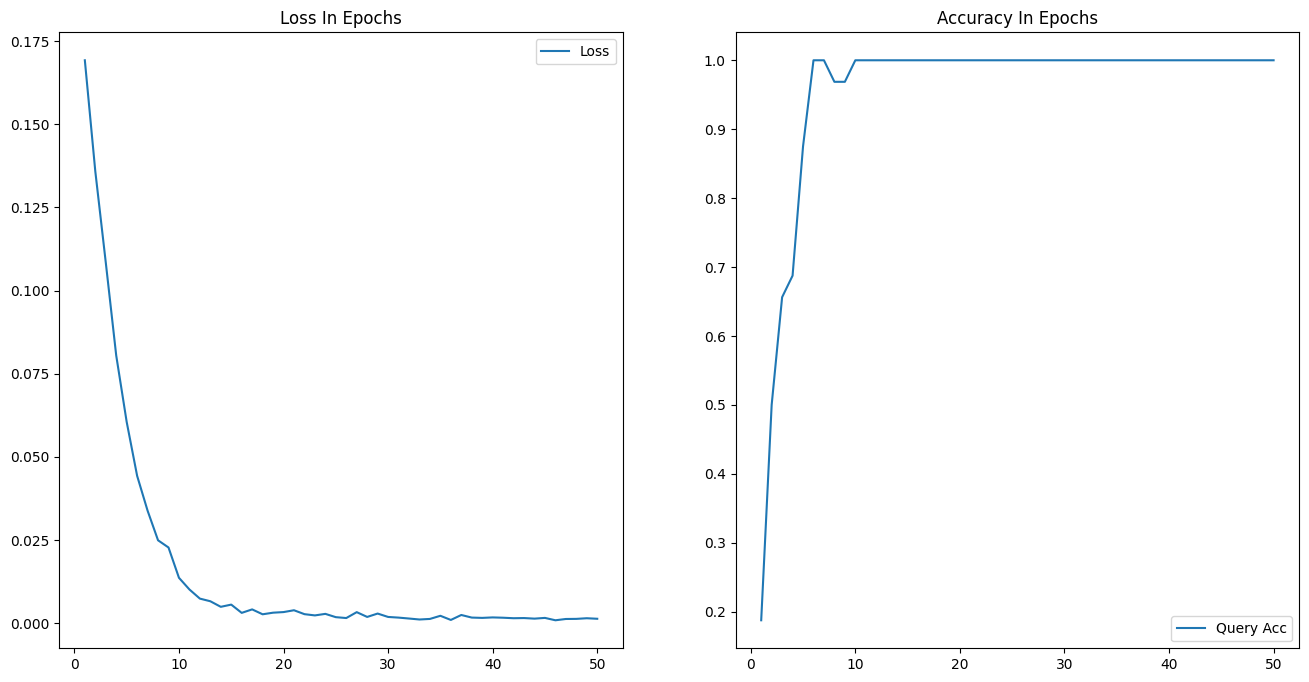

In [3]:
from train_test import train, test

train(ensemble_net, train_loader, args=args,
            num_epochs=50, lr=0.002, weight_decay=0.,
            scheduler_stepsz=10, scheduler_gamma=0.8) 

Test Batch   0   |   Query Acc:100.00%
Test Batch   1   |   Query Acc:75.00%
Test Batch   2   |   Query Acc:87.50%
Test Batch   3   |   Query Acc:100.00%
Test Batch   4   |   Query Acc:100.00%
Test Batch   5   |   Query Acc:100.00%
Test Batch   6   |   Query Acc:100.00%
Test Batch   7   |   Query Acc:100.00%
Test Batch   8   |   Query Acc:100.00%
Test Batch   9   |   Query Acc:100.00%
Test Batch  10   |   Query Acc:87.50%
Test Batch  11   |   Query Acc:100.00%
Test Batch  12   |   Query Acc:100.00%
Test Batch  13   |   Query Acc:100.00%
Test Batch  14   |   Query Acc:87.50%
Average Query Acc:95.83%


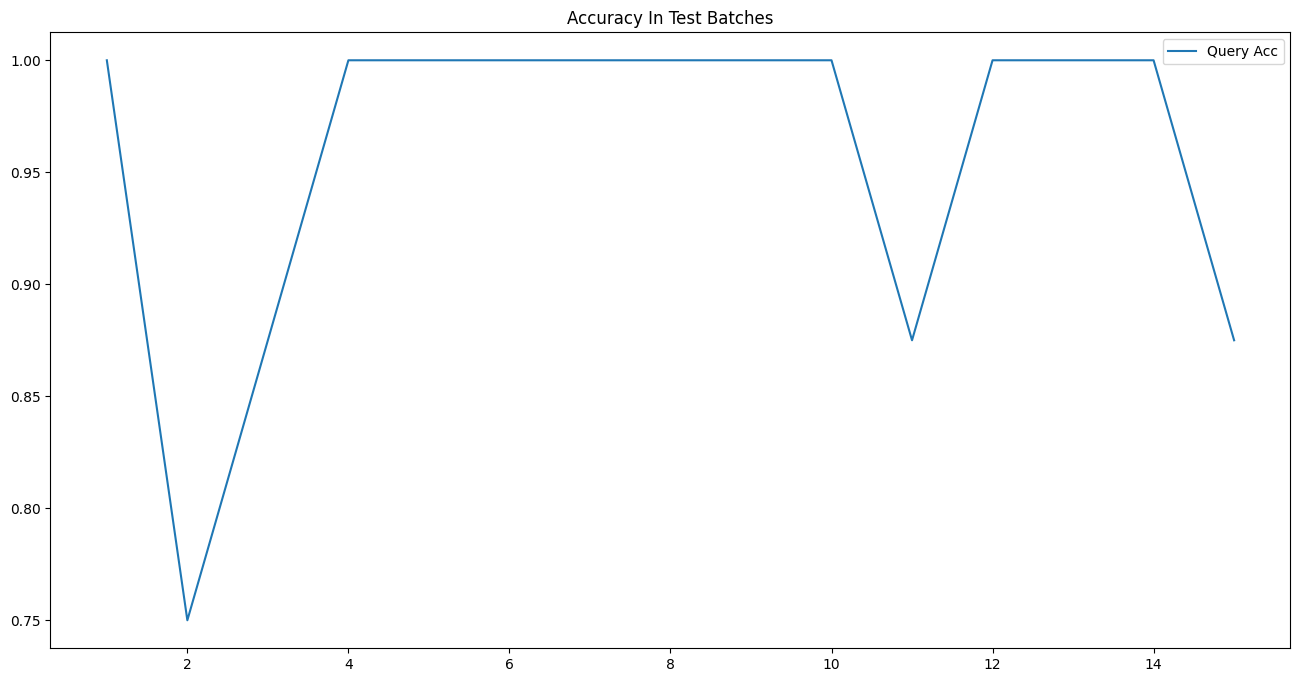

In [4]:
avg_test_acc = test(ensemble_net, test_loader, args)
#utils.save_results(args, avg_test_acc)